# PyMongoArrow!

PyMongoArrow is a PyMongo extension containing tools for loading MongoDB query result sets as Apache Arrow tables, NumPy arrays, and Pandas or Polars DataFrames.

This notebook illustrates using PyMongoArrow along with Pandas and Polars to reshape and evaluate data in ways that are natural in a DataFrame. It also illustrates how the aggregation framework can simplify data preparation for DataFrames, and sometimes do some of the heavy lifting of aggregation and calculation. The two work very well together!

In [21]:
from datetime import datetime
import os
from typing import Any, Mapping

import pymongo
from pymongoarrow.api import *
from pymongoarrow.monkey import patch_all
patch_all()

import pandas as pd
import polars

In [4]:
client = pymongo.MongoClient(os.environ["MDB_URI"])
if int(client.db.command('ping')['ok']) == 1:
    print("Connected")
else:
    print("Not connected!")

sales_collection = client.get_default_database().get_collection("sales")

Connected


# Exploring the Source Data

This collection contains documents that describe a sale from a business, describing the items bought, and the customer who bought the products.

In [5]:
sales_collection.find_one()

{'_id': ObjectId('5bd761dcae323e45a93ccfe8'),
 'saleDate': datetime.datetime(2015, 3, 23, 21, 6, 49, 506000),
 'items': [{'name': 'printer paper',
   'tags': ['office', 'stationary'],
   'price': Decimal128('40.01'),
   'quantity': 2},
  {'name': 'notepad',
   'tags': ['office', 'writing', 'school'],
   'price': Decimal128('35.29'),
   'quantity': 2},
  {'name': 'pens',
   'tags': ['writing', 'office', 'school', 'stationary'],
   'price': Decimal128('56.12'),
   'quantity': 5},
  {'name': 'backpack',
   'tags': ['school', 'travel', 'kids'],
   'price': Decimal128('77.71'),
   'quantity': 2},
  {'name': 'notepad',
   'tags': ['office', 'writing', 'school'],
   'price': Decimal128('18.47'),
   'quantity': 2},
  {'name': 'envelopes',
   'tags': ['stationary', 'office', 'general'],
   'price': Decimal128('19.95'),
   'quantity': 8},
  {'name': 'envelopes',
   'tags': ['stationary', 'office', 'general'],
   'price': Decimal128('8.08'),
   'quantity': 3},
  {'name': 'binder',
   'tags': ['sc

In [6]:
def limit(count: int) -> Mapping[str, Any]:
    return { '$limit': count }

def unwind(path: str) -> Mapping[str, Any]:
    return {
        '$unwind': path
    }

def sample(size: int) -> Mapping[str, Any]:
    return {
        '$sample': {
            'size': size
        }
    }

def project(mapping: Mapping[str, Any]) -> Mapping[str, Any]:
    return {
        '$project': mapping
    }

# Aggregation for Data Reshaping

Aggregation queries are a great way of reshaping, filtering, and pre-processing data before exporting to dataframes.

`$unwind` provides multiple documents for each input document, one for each value in the collection specified.

In [7]:
sales_collection.aggregate([
    unwind('$items'),
    limit(1),
]).next()

{'_id': ObjectId('5bd761dcae323e45a93ccfe8'),
 'saleDate': datetime.datetime(2015, 3, 23, 21, 6, 49, 506000),
 'items': {'name': 'printer paper',
  'tags': ['office', 'stationary'],
  'price': Decimal128('40.01'),
  'quantity': 2},
 'storeLocation': 'Denver',
 'customer': {'gender': 'M',
  'age': 42,
  'email': 'cauho@witwuta.sv',
  'satisfaction': 4},
 'couponUsed': True,
 'purchaseMethod': 'Online'}

# Pandas

PyMongoArrow can directly create Pandas DataFrame objects from query results, using `find_pandas_all` and `aggregate_pandas_all`.

In [8]:
aggregate_pandas_all(sales_collection, [
    sample(1000),
    unwind('$items'),
])

,_id,saleDate,items,storeLocation,customer,couponUsed,purchaseMethod
0,5bd761deae323e45a93cdceb,2017-09-07 15:50:09.610,"{'name': 'envelopes', 'tags': ['stationary', '...",Denver,"{'gender': 'F', 'age': 40, 'email': 'gagso@lij...",False,In store
1,5bd761deae323e45a93cdceb,2017-09-07 15:50:09.610,"{'name': 'pens', 'tags': ['writing', 'office',...",Denver,"{'gender': 'F', 'age': 40, 'email': 'gagso@lij...",False,In store
2,5bd761ddae323e45a93cd9e8,2014-03-08 22:50:54.025,"{'name': 'binder', 'tags': ['school', 'general...",Denver,"{'gender': 'F', 'age': 49, 'email': 'caif@afuv...",False,Online
3,5bd761ddae323e45a93cd9e8,2014-03-08 22:50:54.025,"{'name': 'pens', 'tags': ['writing', 'office',...",Denver,"{'gender': 'F', 'age': 49, 'email': 'caif@afuv...",False,Online
4,5bd761ddae323e45a93cd9e8,2014-03-08 22:50:54.025,"{'name': 'notepad', 'tags': ['office', 'writin...",Denver,"{'gender': 'F', 'age': 49, 'email': 'caif@afuv...",False,Online
...,...,...,...,...,...,...,...
5405,5bd761ddae323e45a93cd43a,2015-05-10 14:16:11.037,"{'name': 'pens', 'tags': ['writing', 'office',...",Denver,"{'gender': 'M', 'age': 62, 'email': 'azolum@oh...",False,In store
5406,5bd761ddae323e45a93cd43a,2015-05-10 14:16:11.037,"{'name': 'printer paper', 'tags': ['office', '...",Denver,"{'gender': 'M', 'age': 62, 'email': 'azolum@oh...",False,In store
5407,5bd761ddae323e45a93cd43a,2015-05-10 14:16:11.037,"{'name': 'backpack', 'tags': ['school', 'trave...",Denver,"{'gender': 'M', 'age': 62, 'email': 'azolum@oh...",False,In store
5408,5bd761ddae323e45a93cd43a,2015-05-10 14:16:11.037,"{'name': 'notepad', 'tags': ['office', 'writin...",Denver,"{'gender': 'M', 'age': 62, 'email': 'azolum@oh...",False,In store


In [9]:
items_panda: pd.DataFrame = aggregate_pandas_all(
    sales_collection, 
    [
        sample(1000),
        unwind('$items'),
        project({
            'saleDate': 1,
            'item': '$items.name',
            'tags': '$items.tags',
            'storeLocation': 1,
            'customerAge': '$customer.age',
            'couponUsed': 1,
            'purchaseMethod': 1
        })
    ],
)
items_panda

,_id,saleDate,storeLocation,couponUsed,purchaseMethod,item,tags,customerAge
0,5bd761ddae323e45a93cd920,2017-03-28 15:39:32.649,New York,False,In store,printer paper,"[office, stationary]",62
1,5bd761ddae323e45a93cd920,2017-03-28 15:39:32.649,New York,False,In store,notepad,"[office, writing, school]",62
2,5bd761ddae323e45a93cd920,2017-03-28 15:39:32.649,New York,False,In store,notepad,"[office, writing, school]",62
3,5bd761ddae323e45a93cd920,2017-03-28 15:39:32.649,New York,False,In store,binder,"[school, general, organization]",62
4,5bd761ddae323e45a93cd920,2017-03-28 15:39:32.649,New York,False,In store,laptop,"[electronics, school, office]",62
...,...,...,...,...,...,...,...,...
5328,5bd761ddae323e45a93cd4ea,2013-04-05 22:00:08.770,Seattle,False,Phone,binder,"[school, general, organization]",33
5329,5bd761dcae323e45a93cd2f4,2015-03-25 15:48:12.634,San Diego,False,In store,pens,"[writing, office, school, stationary]",60
5330,5bd761dcae323e45a93cd2f4,2015-03-25 15:48:12.634,San Diego,False,In store,binder,"[school, general, organization]",60
5331,5bd761dcae323e45a93cd2f4,2015-03-25 15:48:12.634,San Diego,False,In store,pens,"[writing, office, school, stationary]",60


In [14]:
median_ages_by_item = items_panda.pivot_table(index='item', columns=['storeLocation'], values=['customerAge'], aggfunc="median")
median_ages_by_item

customerAge                                         
storeLocation      Austin Denver London New York San Diego Seattle
item                                                              
backpack             50.0   48.0   44.0     40.5      42.5    42.5
binder               46.0   50.0   45.0     44.0      49.0    42.0
envelopes            47.0   50.0   45.0     41.0      49.0    42.0
laptop               46.5   46.0   45.0     43.0      53.0    47.0
notepad              49.5   48.0   45.0     47.0      46.0    42.0
pens                 44.0   47.0   44.0     39.0      50.5    44.0
printer paper        46.0   48.0   44.0     42.0      52.5    43.0

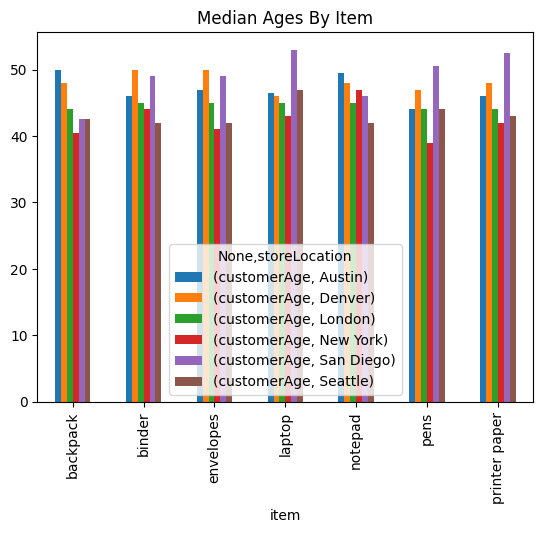

In [20]:
median_ages_by_item.plot(title='Median Ages By Item', kind='bar');

# Polars!

PyMongoArrow supports exporting to Polars dataframes.

In [11]:
sales_polars: polars.DataFrame = aggregate_polars_all(
    sales_collection, 
    [
        sample(1000),
        project({
            # Convert ObjectID to a string for neatness:
            '_id': { '$convert': { 'input': '$_id', 'to': 'string' } },
            'saleDate': 1,
            #'item': '$items.name',
            #'tags': '$items.tags',
            'storeLocation': 1,
            'customerAge': '$customer.age',
            'couponUsed': 1,
            'purchaseMethod': 1
        })
    ],
)
sales_polars

saleDate,storeLocation,couponUsed,purchaseMethod,_id,customerAge
datetime[ms],str,bool,str,str,i32
2015-11-27 20:46:04.462,"""Denver""",false,"""In store""","""5bd761deae323e45a93cddf9""",29
2013-08-19 08:24:27.160,"""Denver""",false,"""Online""","""5bd761deae323e45a93ce32b""",66
2015-07-30 15:08:35.650,"""Austin""",true,"""Online""","""5bd761dcae323e45a93cd2c6""",47
2016-07-22 14:03:17.567,"""Denver""",false,"""Phone""","""5bd761ddae323e45a93cd8c4""",55
2016-10-01 16:04:51.892,"""Seattle""",false,"""In store""","""5bd761deae323e45a93cdf1d""",51
…,…,…,…,…,…
2014-03-25 07:56:37.781,"""Seattle""",false,"""Online""","""5bd761ddae323e45a93cd74a""",20
2015-08-01 07:32:58.627,"""Austin""",false,"""Online""","""5bd761deae323e45a93cdf58""",59
2013-11-13 10:47:57.564,"""Seattle""",false,"""In store""","""5bd761ddae323e45a93cd91c""",73


Once in a Polars DataFrame, you can use all of its power for reshaping, visualising and otherwise understanding your data:

In [12]:
sales_polars.pivot(values='couponUsed', index='storeLocation', columns='couponUsed', aggregate_function='len')

storeLocation,false,true
str,u32,u32
"""Denver""",294,36
"""Austin""",114,9
"""Seattle""",194,22
"""London""",151,19
"""New York""",81,8
"""San Diego""",65,7


In [13]:
df: polars.DataFrame = aggregate_polars_all(
    sales_collection, 
    [
        sample(1000),
        {
            '$addFields': {
                'couponTrue': { '$toInt': '$couponUsed' },
                'couponFalse': { '$toInt':{ '$not':  '$couponUsed' }},
            }
        },
        {
            '$group': {
                '_id': '$storeLocation',
                'couponsUsed': {'$sum': '$couponTrue'}, 
                'couponsNotUsed': {'$sum': '$couponFalse'}, 
                'medianAge': {'$median': { 'input': '$customer.age', 'method': 'approximate' }},
            }
        },
    ],
)
df

_id,couponsUsed,couponsNotUsed,medianAge
str,i32,i32,f64
"""New York""",10,74,42.0
"""Denver""",27,263,46.0
"""San Diego""",8,73,46.0
"""London""",10,167,43.0
"""Seattle""",23,212,43.0
"""Austin""",12,121,46.0
